<h1 align="center"> 
DATS 6202, Fall 2018, Homework_4 (solution)
</h1>

<h4 align="center"> 
Yuxiao Huang ([yuxiaohuang@gwu.edu](mailto:yuxiaohuang@gwu.edu))
</h4>

## Note
- Complete the missing parts indicated by # Implement me
- Submit an ipynb file named Homework_4.ipynb to [blackboard](https://blackboard.gwu.edu) folder /Assignments/Homework_4/
-  We expect you to follow a reasonable programming style. While we do not mandate a specific style, we require that your code to be neat, clear, **documented/commented** and above all consistent. **Marks will be deducted if these are not followed.**

## Overview
Here we will apply random forest and logistic regression to [Drug consumption (quantified) data](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29). While there are many targets in the data, we focus on only one of them, Heroin, and one of its class labels, CL0 (Never used). Please click on the hyperlink above to see details of the data.

The goal is to compare random forest and logistic regression in terms of classification accuracy and detecting feature importance.

Here we go!

## Load the Drug consumption (quantified) data

In [1]:
import warnings
warnings.filterwarnings('ignore')
    
import pandas as pd

# Load the data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data', header=None)

# Specify the name of the columns
df.columns = ['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']

# Show the header and the first five rows
df.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


## Remove unnecessary columns
Note:
- In function $\texttt{df.drop}$ (line 5), axis=1 means that we would like to remove a column. <font color='red'>This must be specified since the default value is zero (i.e., we would like to remove a row).</font>

In [2]:
# Specify the name of the columns that should be removed
columns_remove = ['ID', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']

# Remove the columns above (in columns_remove)
df = df.drop(columns_remove, axis=1)

# Show the header and the first five rows
df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Heroin
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL0


## Remove rows with missing values

In [3]:
import numpy as np

print('Number of rows before removing rows with missing values: ' + str(df.shape[0]))

# Replace ? with np.NaN
df = df.replace('?', np.NaN)

# Remove rows with np.NaN
df = df.dropna(how='any')

print('Number of rows after removing rows with missing values: ' + str(df.shape[0]))

Number of rows before removing rows with missing values: 1885
Number of rows after removing rows with missing values: 1885


## Get the feature and target vector

In [4]:
# Specify the name of the target
target = 'Heroin'

# Get the target vector
y = df[target].values

# Specify the name of the features
features = list(df.drop(target, axis=1).columns)

# Get the feature vector
X = df[features].values

## Encode the target

In [5]:
from sklearn.preprocessing import LabelEncoder

# Declare the LabelEncoder
le = LabelEncoder()

print('The unique value in y before encoding: ' + (', ').join([str(val) for val in np.unique(y)]))

# Encode the target
y = le.fit_transform(y)

print('The unique value in y after encoding: ' + (', ').join([str(val) for val in np.unique(y)]))

The unique value in y before encoding: CL0, CL1, CL2, CL3, CL4, CL5, CL6
The unique value in y after encoding: 0, 1, 2, 3, 4, 5, 6


## Divide the data into training and testing

In [6]:
from sklearn.model_selection import train_test_split

# Randomly choose 30% of the data for testing (set randome_state as 0 and stratify as y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## Standardize the features

In [7]:
from sklearn.preprocessing import StandardScaler

# Declare the StandardScaler
std_scaler = StandardScaler()

# Standardize the features in the training data
X_train = std_scaler.fit_transform(X_train)

# Standardize the features in testing data
X_test = std_scaler.transform(X_test)

## Fit random forest and print the classification accuracy 
Note:
- In function $\texttt{RandomForestClassifier}$ (line 4), <font color='red'>class_weight='balanced' *"uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data"*</font> (as specified in the [sklearn RandomForestClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). This is used for addressing biased target data, which is the case here (the proportion for class label CL0 is around 85%).

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Delcare the model
rf = RandomForestClassifier(random_state=0, class_weight='balanced')

# Train the model
rf.fit(X_train, y_train)

# Print the classification accuracy
print('The accuracy of random forest is: ' + str(rf.score(X_test, y_test)))

The accuracy of random forest is: 0.8533568904593639


## Fit logistic regression and print the classification accuracy 
Note:
- For the same reason mentioned above, in function $\texttt{LogisticRegression}$ (line 4), <font color='red'>class_weight was set as 'balanced'.

In [9]:
from sklearn.linear_model import LogisticRegression

# Delcare the model
lr = LogisticRegression(random_state=0, class_weight='balanced')

# Train the model
lr.fit(X_train, y_train)

# Print the classification accuracy
print('The accuracy of logistic regression is: ' + str(lr.score(X_test, y_test)))

The accuracy of logistic regression is: 0.7208480565371025


## Discussion
The results show that random forest has higher accuracy compared to logistic regression, which is usually the case in reality. Thus random forest could be a better choice when the goal is to achieve higher classification accuracy. However, as shown in the midterm (the distributions), logistic regression has its own strength. More on this later.

## Show the point estimation of feature importance provided by random forest

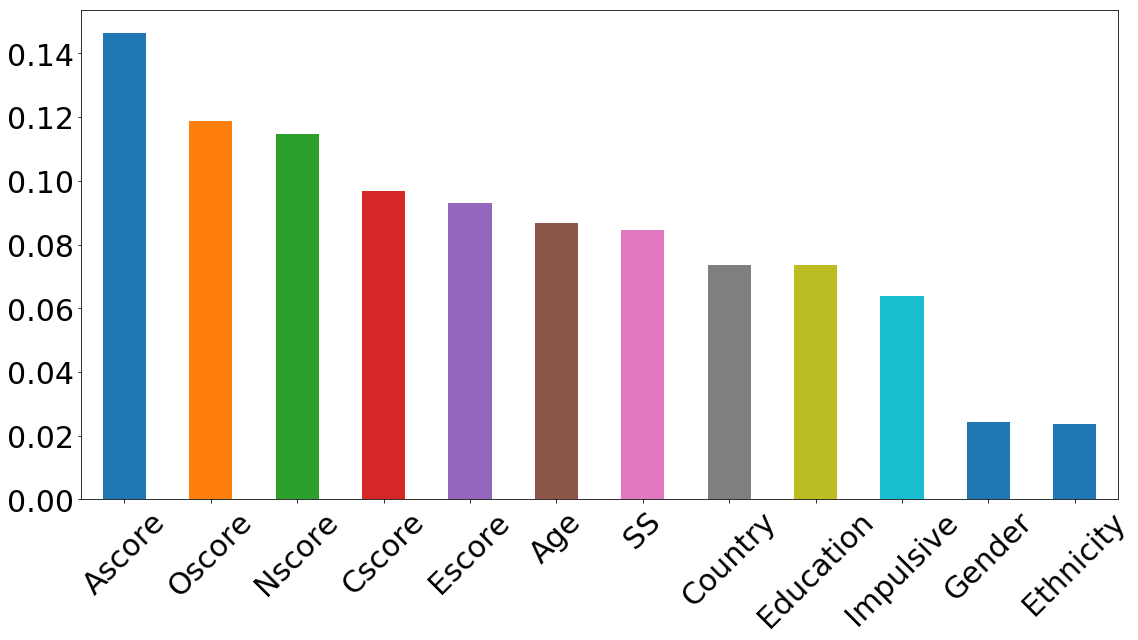

In [10]:
import matplotlib.pyplot as plt

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(rf.feature_importances_, df.drop(target, axis=1).columns)

# Sort the array in descending order of the importances
f_importances = f_importances.sort_values(ascending=False)

# Draw the bar Plot from f_importances 
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=30)

# Show the plot
plt.tight_layout()
plt.show()

## Discussion
The histogram above shows the importance of the 12 features in descending order. The meaning for the top 5 features are as follows (the meaning for the other features can be seen in the [documentation of the dataset](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29)):
- Ascore (Agreeableness)
- Oscore (Openness to experience)
- Nscore (Neuroticism)
- Cscore (Conscientiousness)
- Escore (Extraversion)

For the features above, having the top 5 importance means that they have the top 5 predictive power (in terms of predicting the target, Heroin). Thus if we only want to select five features for fitting a model, they are the ones that should be chosen.

While this is useful, let us see something really interesting. Recall in the midterm we played a trick so that logistic regression could detect, not the point estimation of feature importance (as random forest does), but feature importance distribution (with respect to a class label of the target). Below are the importance distributions for the top 5 features above, with respect to class 'CL0' (Never used heroin).

## Reference (code)

In [11]:
def get_distribution(clf, X, y, feature, class_):
    """
    Reference: the code for this function is from Midterm_solution.ipynb
    Calculate the probability distribution of a class based on a feature
    :param clf: the logistic regression classifier
    :param X: the feature vector
    :param y: the target vector
    :param feature: a feature
    :param class_: a class label of the target
    :return: the probability distribution, which is a dictionary 
             where the key is the value of the feature and value the probability:
             distribution = {val_1: proba_1, val_2: proba_2, ..., val_n: proba_n}
             
    """
    
    # Get the column number of the feature
    col = features.index(feature)
    
    # Get the encoded number of the class_
    num = le.transform([class_])
    
    # Get X_sparse
    # Here, all the columns are zeros except for column col, where X_sparse[:, col] = X[:, col]
    X_sparse = np.zeros((X.shape[0], X.shape[1]))
    X_sparse[:, col] = X[:, col]
    
    # Get the unique value and the corresponding index in column col
    vals, idxs = np.unique(X_sparse[:, col], return_index=True)
    
    # Get the distribution
    distribution = {}
    # For each unique index
    for idx in idxs:
        # Get the corresponding value
        val = X_sparse[idx, col]
        
        # Get the probability of each class
        probas = clf.predict_proba(X_sparse[idx, :].reshape(1, -1)).ravel()

        # Get the probability of the class
        proba = probas[num]
        
        distribution[val] = proba
        
    return distribution

def plot_distribution(distribution, feature, class_):
    """
    Reference: the code for this function is from Midterm_solution.ipynb
    Plot the probability distribution of a class based on the feature
    :param distribution: the probability distribution, which is a dictionary 
                         where the key is the value of the feature and value the probability:
                         distribution = {val_1: proba_1, val_2: proba_2, ..., val_n: proba_n}
    :param feature: a feature
    :param class_: a class label of the target
    """
    
    # Get the probabilities
    probas = [distribution[val] for val in sorted(distribution.keys())]
    
    # Get the dataframe
    probas_df = pd.DataFrame(probas)
    
    # Get the values
    vals = sorted(distribution.keys())
    
    # Round down to 2 decimals
    vals = [round(val, 2) for val in vals]

    # Plot the bar chart
    probas_df.plot(kind='bar', figsize=(25, 10), fontsize=30, legend=False)
    plt.xticks(range(len(vals)), vals)
    plt.xlabel('Feature value', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.title('P(' + class_ + ' | ' + feature + ')', fontsize=30, loc='center')
    plt.tight_layout()
    plt.show()

## Show the importance distribution of Ascore

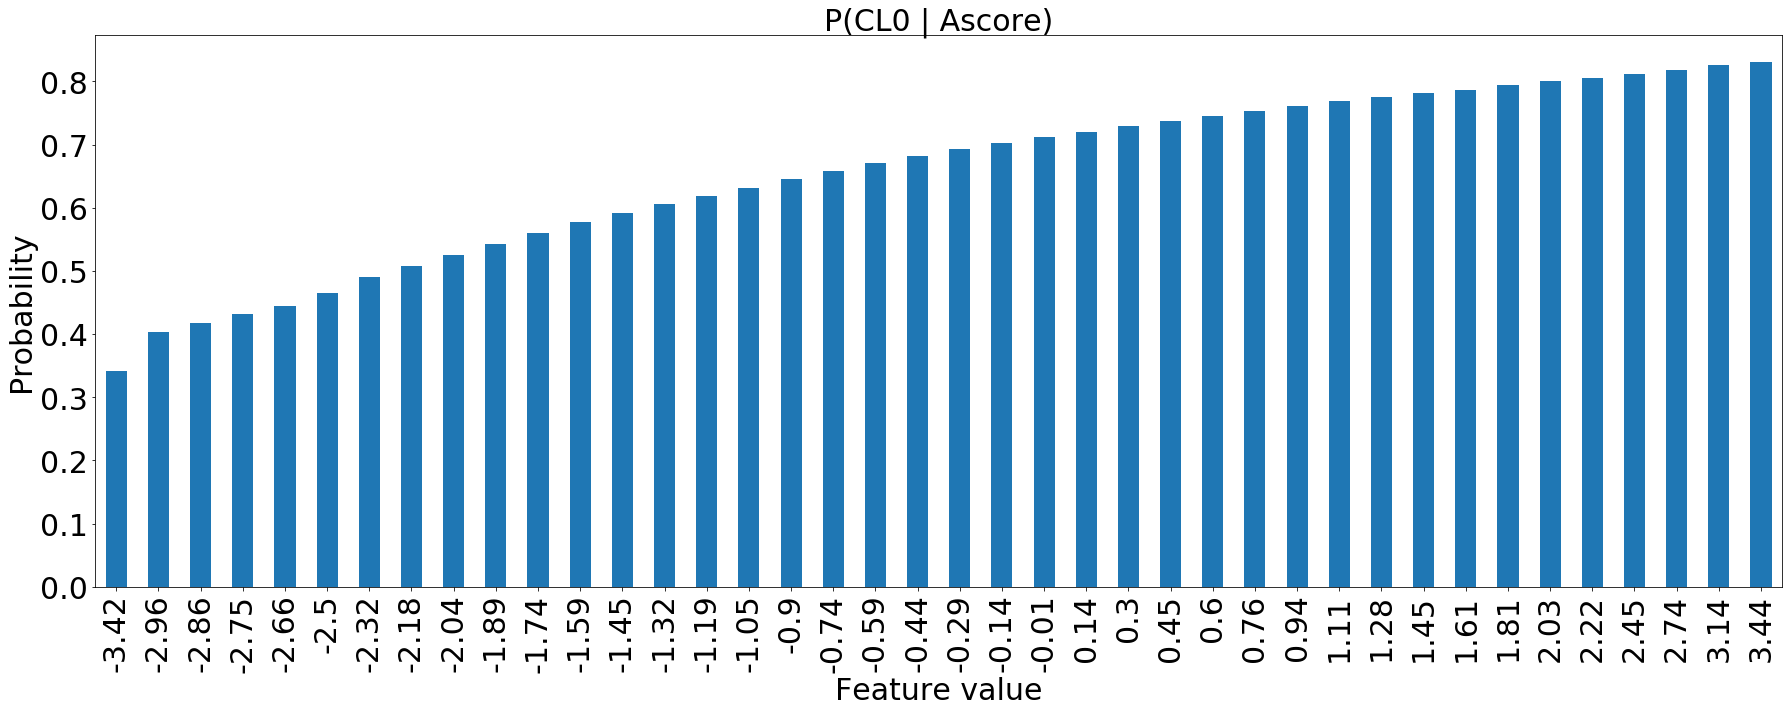

In [12]:
# Get the distribution
distribution = get_distribution(lr, X_train, y_train, 'Ascore', 'CL0')

# Plot the distribution
plot_distribution(distribution, 'Ascore', 'CL0')

## Show the importance distribution of Oscore

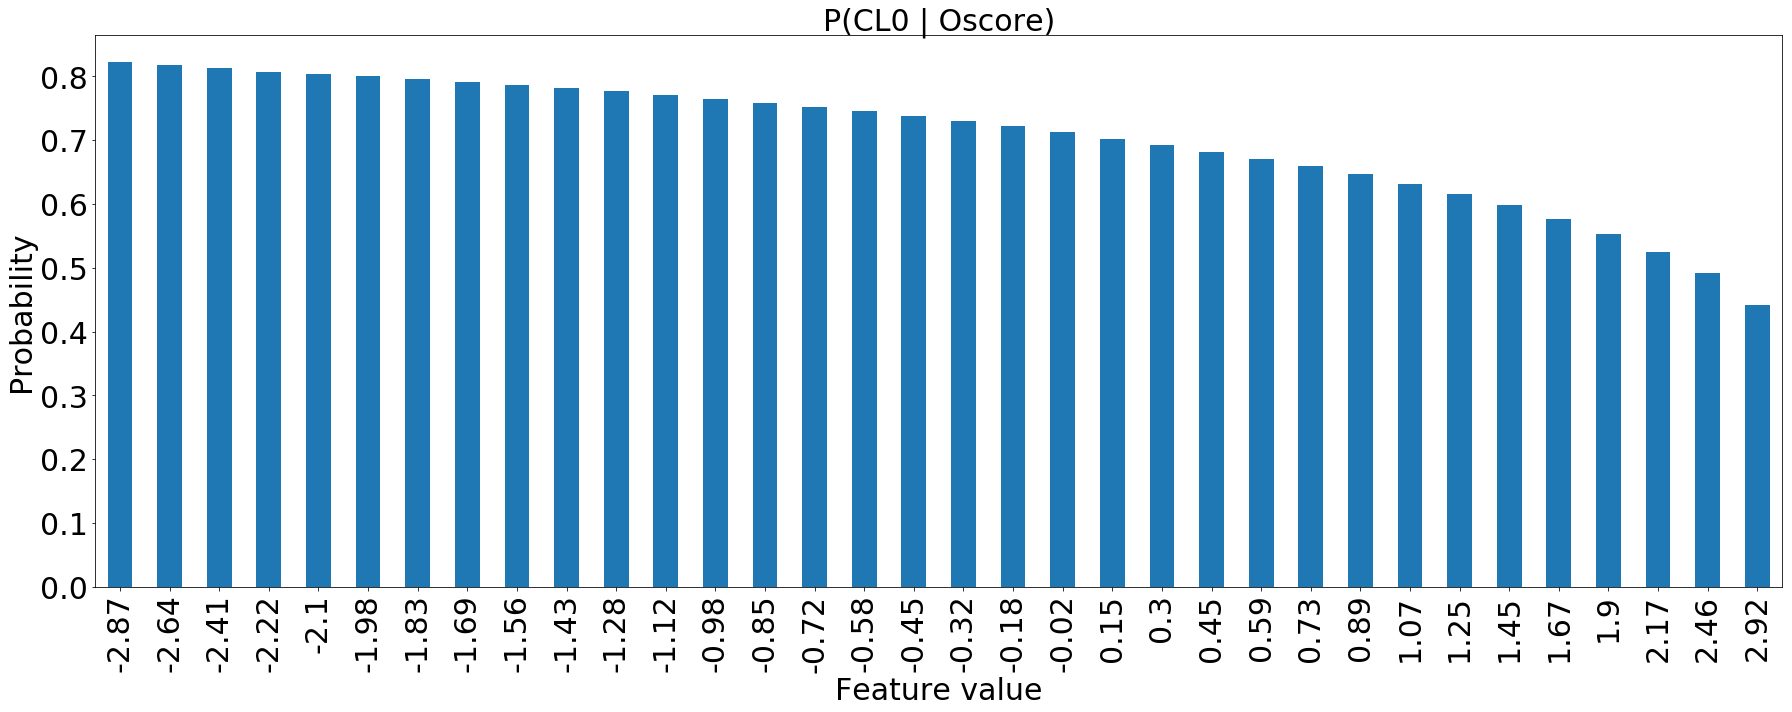

In [13]:
# Get the distribution
distribution = get_distribution(lr, X_train, y_train, 'Oscore', 'CL0')

# Plot the distribution
plot_distribution(distribution, 'Oscore', 'CL0')

## Show the importance distribution of Nscore

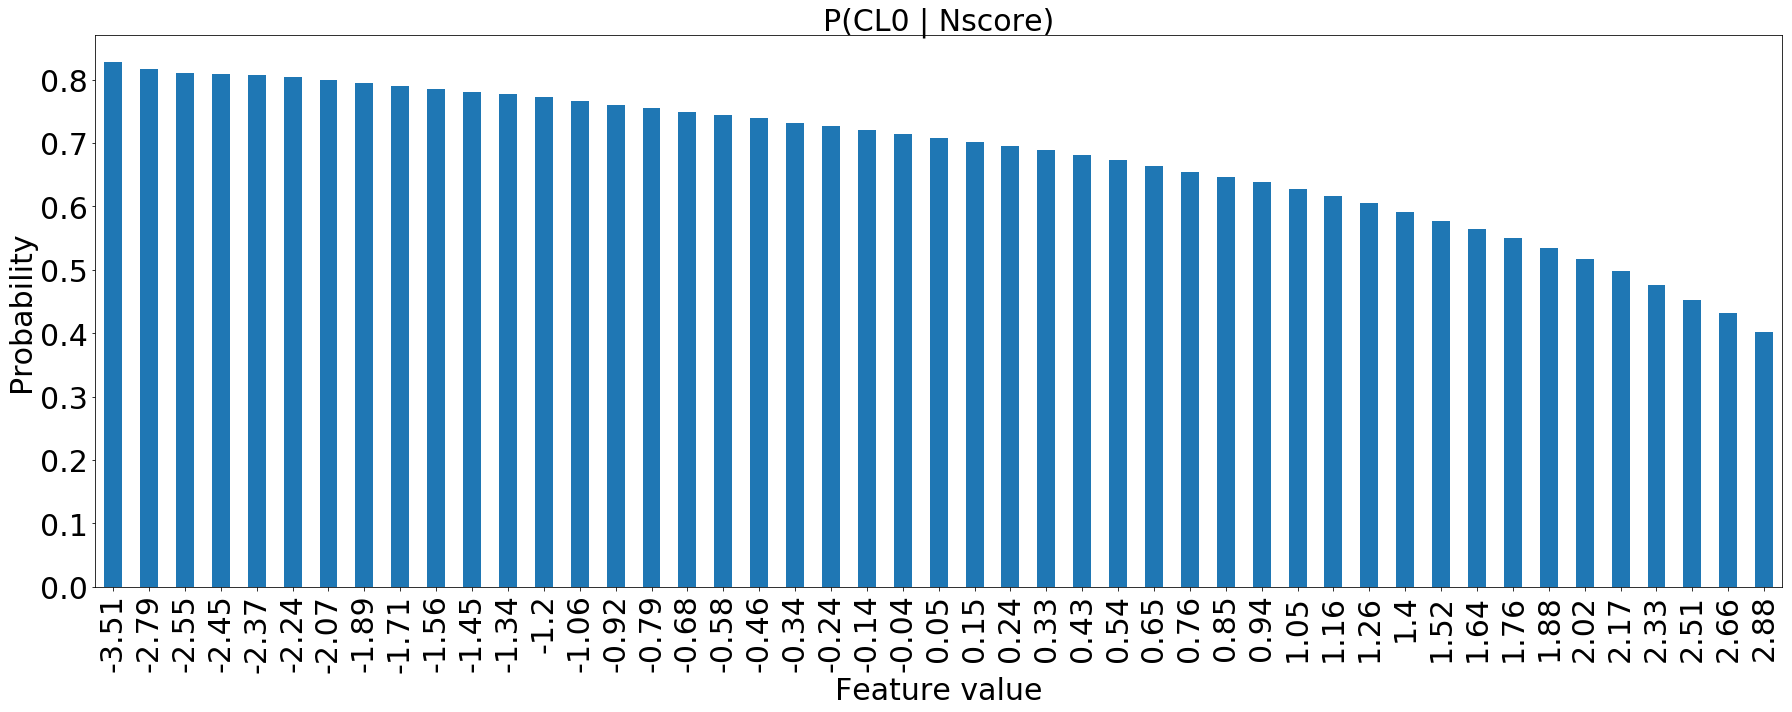

In [14]:
# Get the distribution
distribution = get_distribution(lr, X_train, y_train, 'Nscore', 'CL0')

# Plot the distribution
plot_distribution(distribution, 'Nscore', 'CL0')

## Show the importance distribution of Cscore

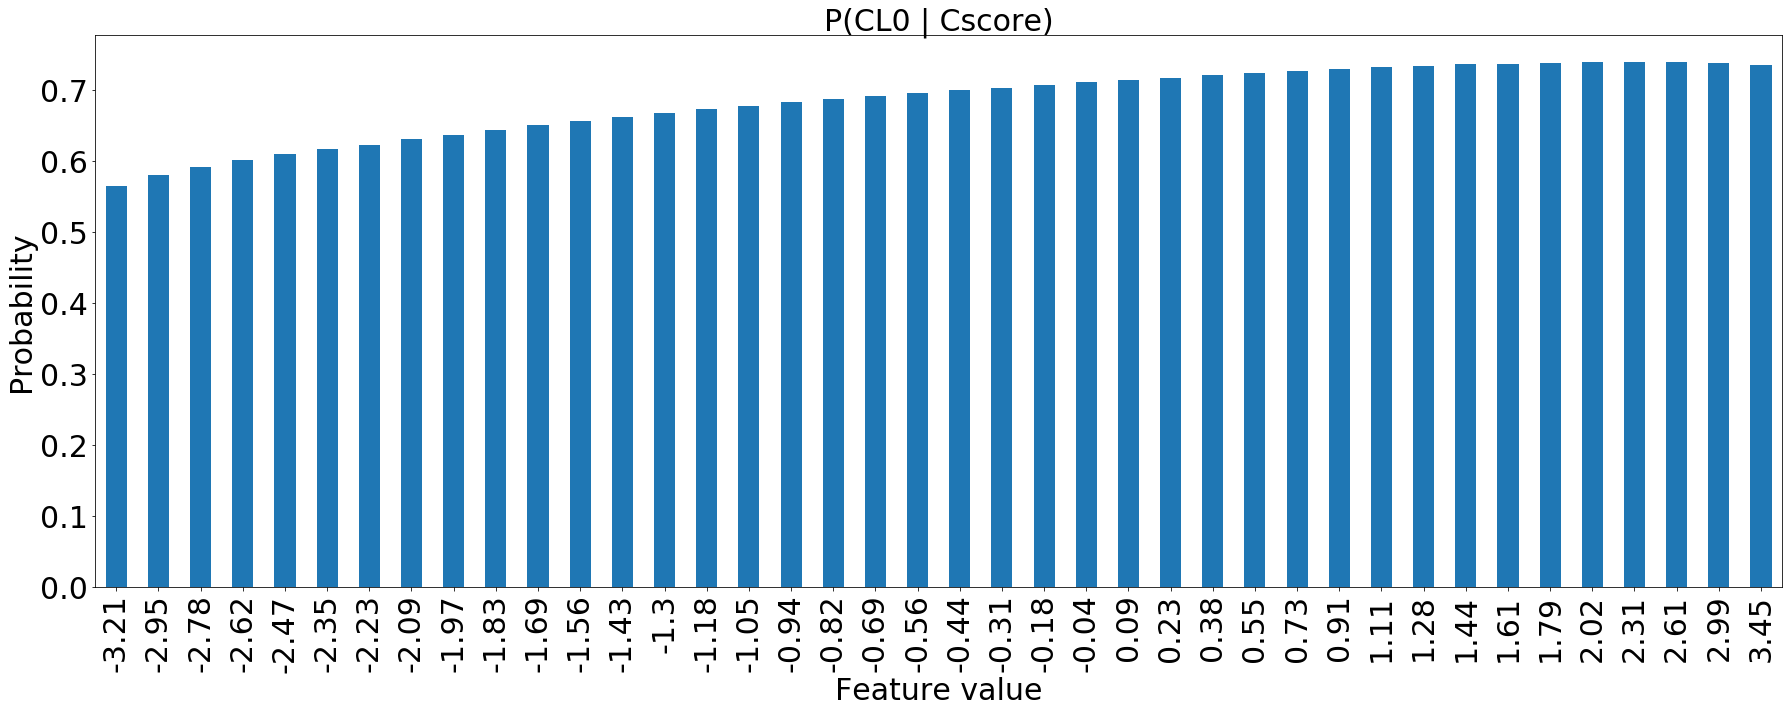

In [15]:
# Get the distribution
distribution = get_distribution(lr, X_train, y_train, 'Cscore', 'CL0')

# Plot the distribution
plot_distribution(distribution, 'Cscore', 'CL0')

## Show the importance distribution of Escore

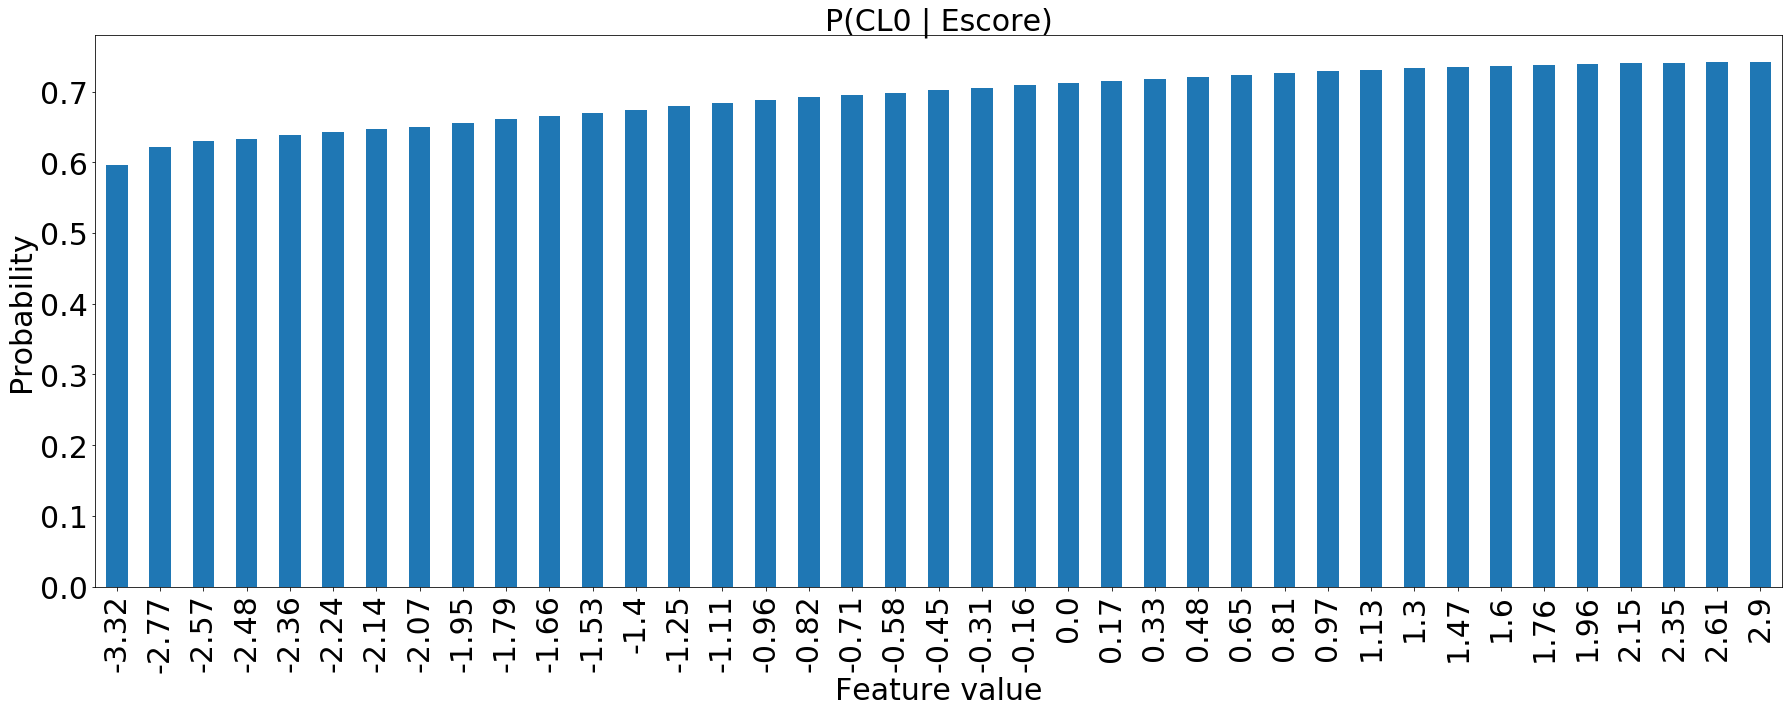

In [16]:
# Get the distribution
distribution = get_distribution(lr, X_train, y_train, 'Escore', 'CL0')

# Plot the distribution
plot_distribution(distribution, 'Escore', 'CL0')

## Discussion

The above five distributions show that Ascore (Agreeableness), Oscore (Openness to experience), Nscore (Neuroticism), Cscore (Conscientiousness), and Escore (Extraversion) can be strong indicator of CL0 (Never used heroin). This echoes the feature importance provided by random forest, where the features have the top 5 importance (as shown in the histogram).

However, what is really interesting about these distributions is that they captured the variance of each feature's predictive power across the feature's value. For example, the distribution for Ascore and Escore show that the more agreeable and extroverted the person the more likely they have never used Heroin. The distribution for Oscore, on the other hand, illustrates that the more open (to experience) the person the less likely they have never used Heroin.

Further, as shown in the distribution for Nscore, higher value of neuroticism leads to lower probability of never used. Conversely, the distribution for Cscore shows that higher value of Conscientiousness results in higher probability of never used. Similar findings have been found in (Terracciano et al. 2008):

*"Compared to never smokers, current cigarette smokers score lower on Conscientiousness and higher on Neuroticism. Similar, but more extreme, is the profile of cocaine/heroin users, which score very high on Neuroticism, especially Vulnerability, and very low on Conscientiousness, particularly Competence, Achievement-Striving, and Deliberation."*

## Reference (paper)

Terracciano, A., Löckenhoff, C. E., Crum, R. M., Bienvenu, O. J., & Costa, P. T. (2008). [Five-Factor Model personality profiles of drug users](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2373294/). BMC psychiatry, 8(1), 22.